In [1]:
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
import scienceplots

plt.style.use('science')

In [8]:
from more_itertools import first_true
from scipy.spatial.distance import cdist

import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal
from pyroll.freiberg_flow_stress import flow_stress

In [3]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

root_dir = Path.cwd()
result_dir = root_dir / "res"

In [4]:
root_dir = Path.cwd()
result_dir = root_dir / "res"

In [5]:
from utilities import *
from in_profile import create_in_profile_for_finishing_train
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3

In [6]:
in_profile = create_in_profile_for_finishing_train(950 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [7]:
rolling_train_rpd1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

rolling_train_rpd1.solve(in_profile)
rolling_train_rpd2.solve(in_profile)
rolling_train_rpd3.solve(in_profile)

Solution iteration of TwoRollPass '23-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '24-V' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '17-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '21-H' exceeded the maximum iteration count of 100. Continuing anyway.


Profile(
    classifiers={'false_round', 'generic_elongation', 'round', 'symmetric'},
    core_temperature=np.float64(1417.6448783239543),
    cross_section=Polygon(
        area=5.826351465694648e-05,
        height=0.008700000000000006,
        perimeter=0.027129051503784137,
        width=0.008249202825551813,
        ),
    length=92.57472262428558,
    material=['BST500', 'steel'],
    ring_temperatures=array([1417.64487832, 1417.49719629, 1417.05200798, 1416.30295854,
           1415.24302216, 1413.86898966, 1412.18601989, 1410.20966206,
           1407.9602822 , 1405.43283224, 1402.18715374]),
    strain=np.float64(0.4292792976073725),
    surface_temperature=np.float64(1402.1871537399763),
    t=np.float64(1.8404522500412914),
    temperature=np.float64(1409.2952201585097),
    weight=2400,
    width=np.float64(0.008249202825551813),
    )

In [14]:
def extract_wear_related_pass_data():
    sequences = [
        {"label": "RPD1", "sequence": rolling_train_rpd1},
        {"label": "RPD2", "sequence": rolling_train_rpd2},
        {"label": "RPD3", "sequence": rolling_train_rpd3}
    ]

    wear_areas = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label:
                        wear_area = calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour )#, debug=True, debug_info={"label": label, "measurement_id": measurement_id})
                        relative_wear_area = wear_area / roll_pass.roll.groove.cross_section.area
                        rolled_mass = tonnage * 1000
                        relative_wear_length = np.mean(pillars_wear_length(roll_pass.roll)) / roll_pass.roll.contact_length
                        neutral_disk = first_true(roll_pass.disk_elements, pred=lambda de: de.out_profile.x > roll_pass.roll.neutral_point)
                        overall_rolled_length =  (roll_pass.velocity * rolled_mass / neutral_disk.out_profile.density) / (neutral_disk.out_profile.cross_section.area * neutral_disk.out_profile.velocity)

                        wear_areas.append({
                            "groove": groove_label,
                            "measurement_id": measurement_id,
                            "label": label,
                            "tonnage": tonnage,
                            "wear_area": wear_area,
                            "relative_wear_area": relative_wear_area,
                            "relative_wear_length": relative_wear_length,
                            "overall_rolled_length": overall_rolled_length
                        })

    return wear_areas

In [15]:
wear_related_pass_data = extract_wear_related_pass_data()

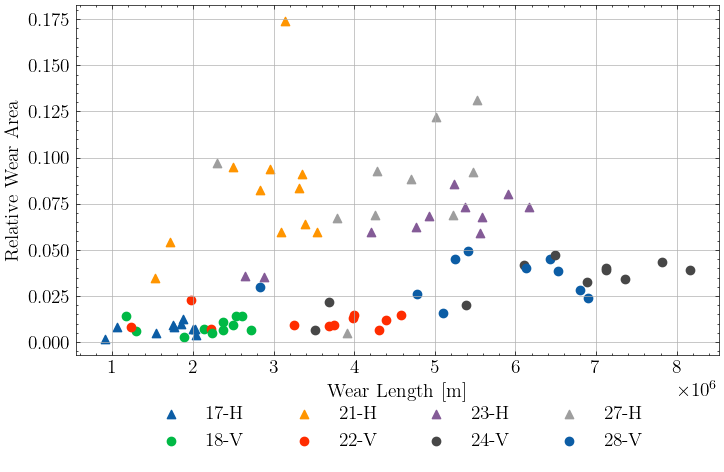

In [21]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, label in enumerate(sorted(set(data['label'] for data in wear_related_pass_data))):
    label_colors[label] = color_cycle[i % len(color_cycle)]

fig: plt.Figure = plt.figure(figsize=(8.3, 6))
ax: plt.Axes
axl: plt.Axes
ax, axl = fig.subplots(nrows=2, height_ratios=[1, 0.2])
ax.set_ylabel('Relative Wear Area')
ax.grid()
ax.set_xlabel('Wear Length [m]')

for wear_data_dicts in wear_related_pass_data:
    if wear_data_dicts['label'] in ["17-H", "21-H", "23-H", "27-H"]:
         marker = '^'
    else:
        marker = 'o'
    ax.scatter(wear_data_dicts['overall_rolled_length'], wear_data_dicts['relative_wear_area'], color=label_colors[wear_data_dicts['label']],
               label=wear_data_dicts['label'], marker=marker)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

axl.axis("off")
axl.legend(by_label.values(), by_label.keys(), ncols=4, loc="lower center")

fig.savefig(result_dir / "wear_area_measurements.pdf",dpi=300, bbox_inches="tight")

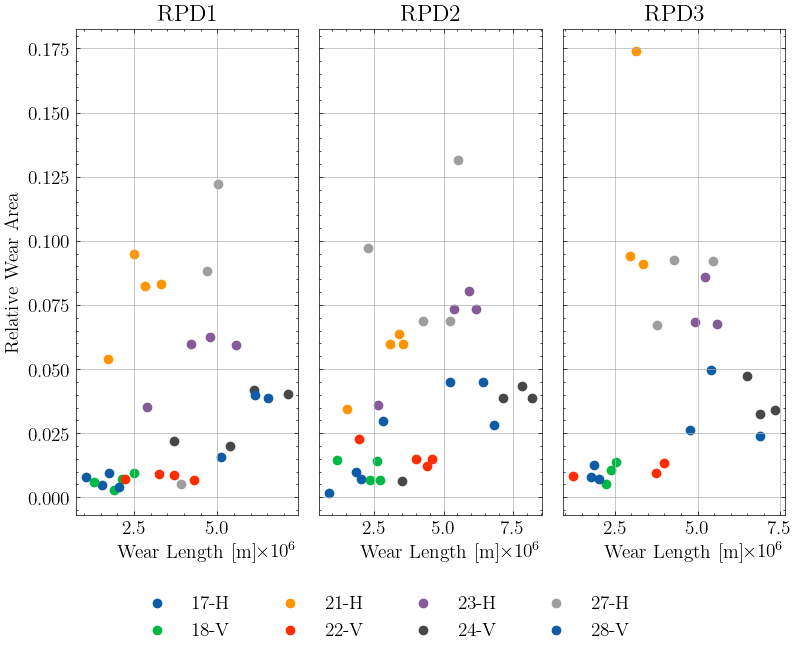

In [20]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, label in enumerate(sorted(set(data['label'] for data in wear_related_pass_data))):
    label_colors[label] = color_cycle[i % len(color_cycle)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.3, 6), sharey=True)
ax1.set_ylabel('Relative Wear Area')

for wear_data_dicts in wear_related_pass_data:
    if wear_data_dicts['groove'] == 'RPD1':
        ax1.scatter(wear_data_dicts['overall_rolled_length'], wear_data_dicts['relative_wear_area'], color=label_colors[wear_data_dicts['label']],
                    label=wear_data_dicts['label'])

ax1.set_title('RPD1')
ax1.set_xlabel('Wear Length [m]')
ax1.grid()

for wear_data_dicts in wear_related_pass_data:
    if wear_data_dicts['groove'] == 'RPD2':
        ax2.scatter(wear_data_dicts['overall_rolled_length'], wear_data_dicts['relative_wear_area'], color=label_colors[wear_data_dicts['label']],
                    label=wear_data_dicts['label'])

ax2.set_title('RPD2')
ax2.set_xlabel('Wear Length [m]')
ax2.grid()

for wear_data_dicts in wear_related_pass_data:
    if wear_data_dicts['groove'] == 'RPD3':
        ax3.scatter(wear_data_dicts['overall_rolled_length'], wear_data_dicts['relative_wear_area'], color=label_colors[wear_data_dicts['label']],
                    label=wear_data_dicts['label'])

ax3.set_title('RPD3')
ax3.set_xlabel('Wear Length [m]')
ax3.grid()

handles2, labels2 = ax1.get_legend_handles_labels()
by_label2 = dict(zip(labels2, handles2))
fig.legend(by_label2.values(), by_label2.keys(), bbox_to_anchor=(0.8, 0.01), ncol=4)

plt.tight_layout()
fig.savefig(result_dir / "wear_area_measurements_per_rpd.pdf",dpi=300, bbox_inches="tight")

In [22]:
values_rpd1 = []
values_rpd2 = []
values_rpd3 = []

for wear_data_dicts in wear_related_pass_data:
    if wear_data_dicts['groove'] == 'RPD1':
        values_rpd1.append(wear_data_dicts)
    if wear_data_dicts['groove'] == 'RPD2':
        values_rpd2.append(wear_data_dicts)
    if wear_data_dicts['groove'] == 'RPD3':
        values_rpd3.append(wear_data_dicts)
values = [values_rpd1, values_rpd2, values_rpd3]

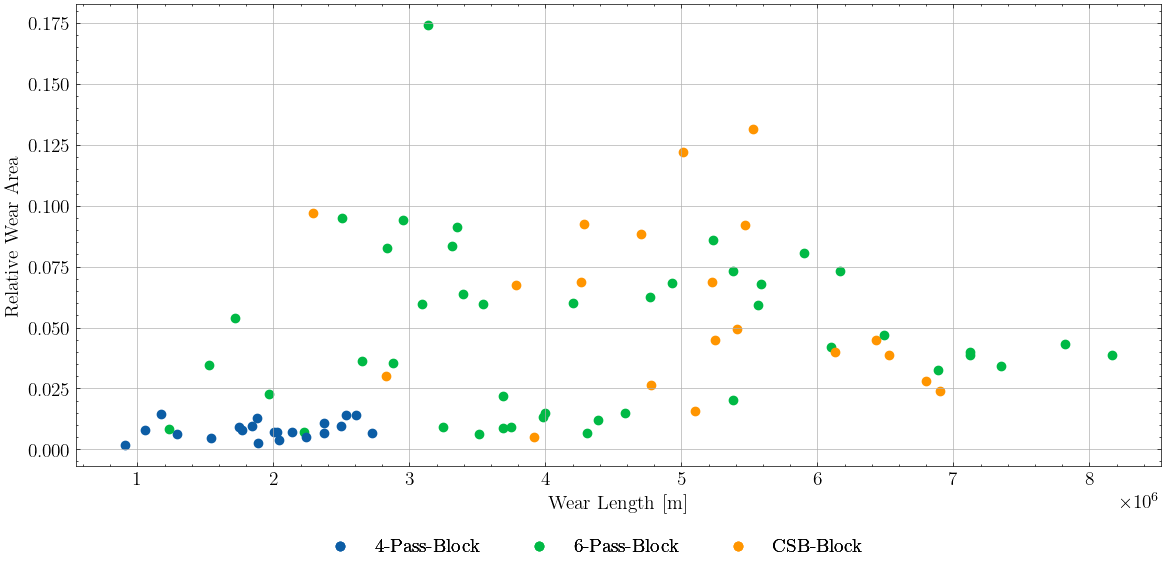

In [23]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, label in enumerate(sorted(set(d['label'] for d in values_rpd1))):
    label_colors[label] = color_cycle[i % len(color_cycle)]

fig, ax = plt.subplots(figsize=(14, 6))
for value in values:
    for wear_data_dicts in value:
        if wear_data_dicts['label'] in ["17-H", "18-V"]:
            ax.scatter(wear_data_dicts['overall_rolled_length'], wear_data_dicts['relative_wear_area'], color='C0', label="4-Pass-Block")
        elif wear_data_dicts['label'] in ["21-H", "22-V", "23-H", "24-V"]:
            ax.scatter(wear_data_dicts['overall_rolled_length'], wear_data_dicts['relative_wear_area'], color='C1', label="6-Pass-Block")

        elif wear_data_dicts['label'] in ["27-H", "28-V"]:
            ax.scatter(wear_data_dicts['overall_rolled_length'], wear_data_dicts['relative_wear_area'], color='C2', label="CSB-Block")

    ax.set_xlabel('Wear Length [m]')
    ax.set_ylabel('Relative Wear Area')
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.7, 0.02), ncol=3)

fig.savefig(result_dir / "wear_area_measurements_per_block.pdf",dpi=300, bbox_inches="tight")